In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


from utils import test
from models import Model

In [2]:
def sample_data(env_name, num_samples, length, crop=(0, 0, 210, 160), resize_shape=(64, 64)):
    env = gym.make(env_name)

    trajectories, actions = [], []

    for _ in range(num_samples):
        single_trajectory, single_actions = [], []

        env.reset()
        for _ in range(length):
            action = env.action_space.sample()
            obs, reward, _, _, _ = env.step(action)

            cropped_obs = obs[crop[0] : crop[2], crop[1] : crop[3], :]
            resized_obs = resize(cropped_obs, (resize_shape[0], resize_shape[1], 3), anti_aliasing=True)
            transposed_obs = np.transpose(resized_obs, (2, 0, 1)) 

            single_actions.append(action)
            single_trajectory.append(transposed_obs)

        trajectories.append(single_trajectory)
        actions.append(single_actions)

    return np.array(trajectories), np.array(actions)


def plot_data(sample):
    sample = (sample + 1) / 2
    frame = np.transpose(sample, (1, 2, 0))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


class AtariDataset(Dataset):
    def __init__(self, env_name, num_samples, length, crop=(0, 0, 210, 160), resize_shape=(64, 64)):
        """ [N, T, C, H, W] """
        self.data, _ = sample_data(env_name, num_samples, length, crop, resize_shape)

    def __len__(self):
        return self.data.shape[0] * self.data.shape[1]

    def __getitem__(self, idx):
        sample_idx = idx // self.data.shape[1]
        frame_idx = idx % self.data.shape[1]
        frame = self.data[sample_idx, frame_idx]
        frame_tensor = torch.tensor(frame, dtype=torch.float32) 

        frame_tensor = frame_tensor * 2 - 1

        white_mask = (frame_tensor[0] > 0.5) & (frame_tensor[1] > 0.5) & (frame_tensor[2] > 0.5)
        frame_tensor[0][white_mask] = 1.0 
        frame_tensor[1][white_mask] = -1.0  
        frame_tensor[2][white_mask] = -1.0  
        return {"image": frame_tensor}

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


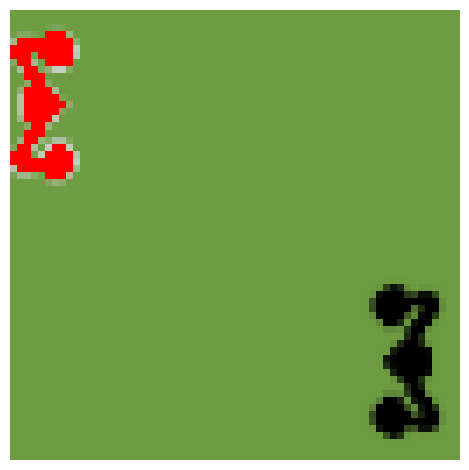

In [3]:
dataset = AtariDataset("ALE/Boxing-v5", 1000, 100, (36, 35, 175, 127))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
plot_data(dataset[0]["image"])

resolution = (64, 64)
num_slots, num_iterations, hidden_dim = 3, 3, 64
model = Model(resolution, num_slots, num_iterations, hidden_dim, (8, 8))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/Users/home/miniconda3/envs/svae/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


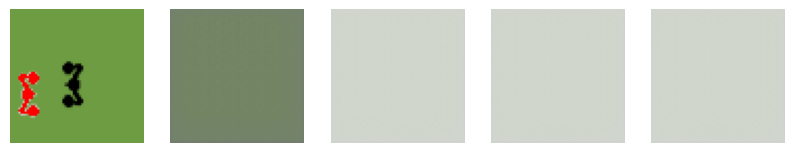

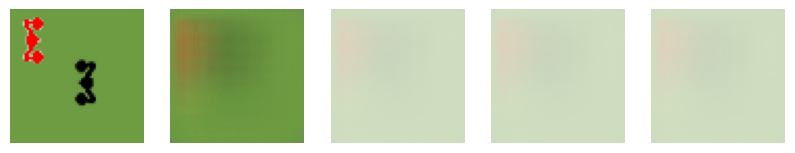

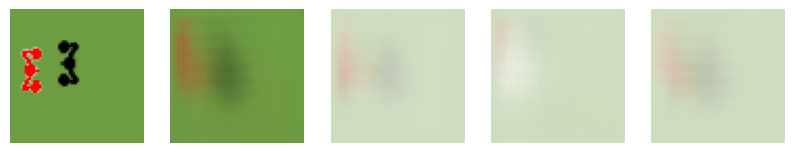

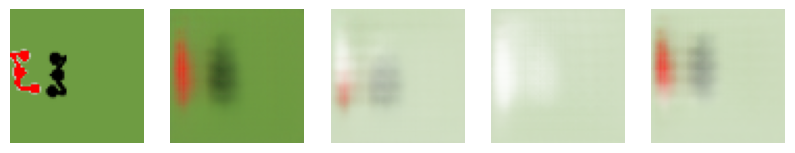

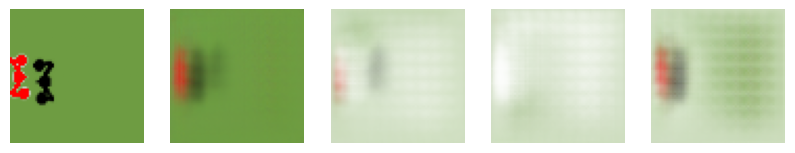

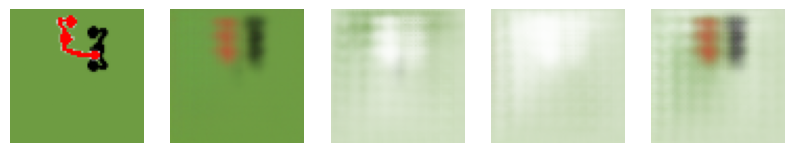

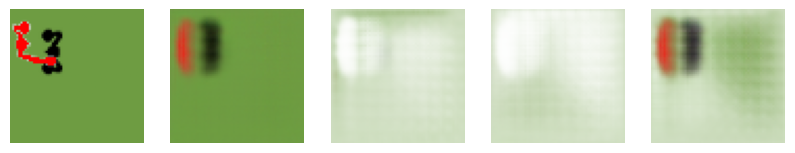

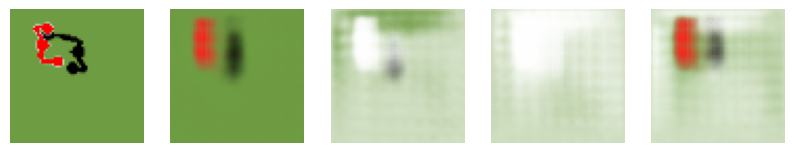

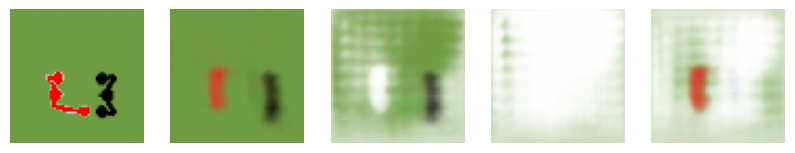

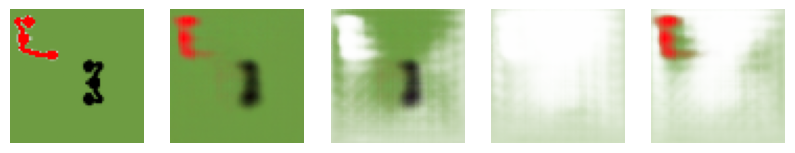

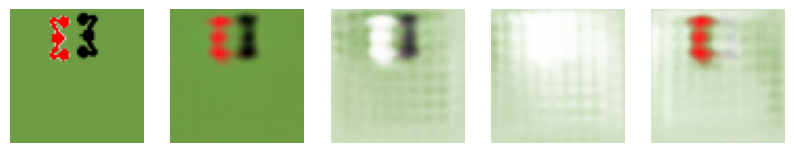

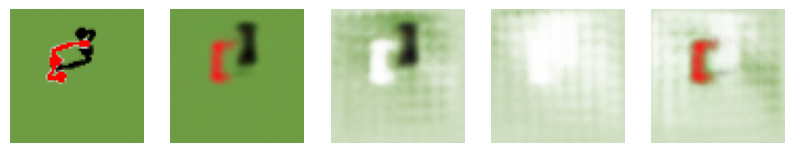

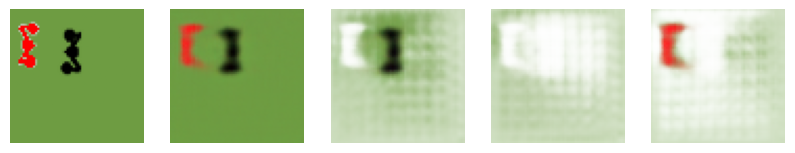

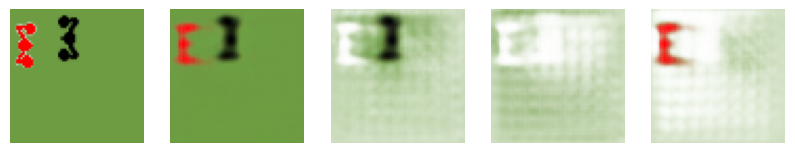

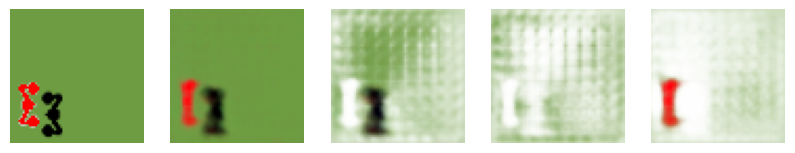

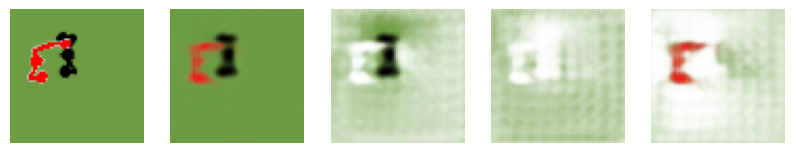

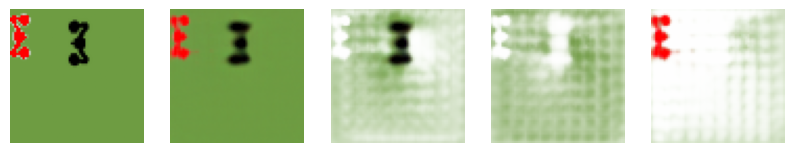

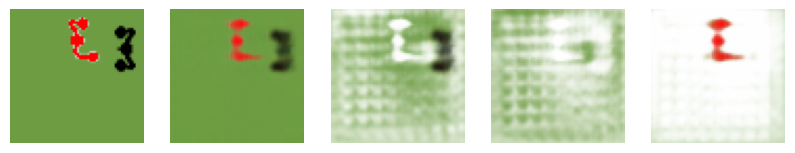

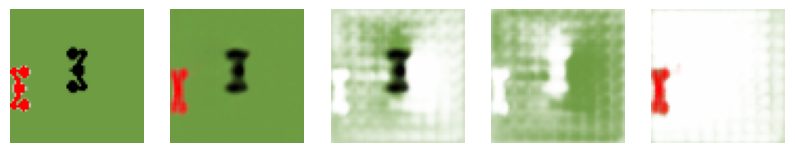

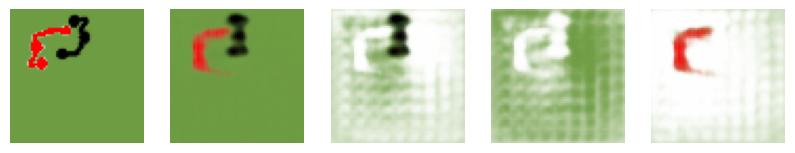

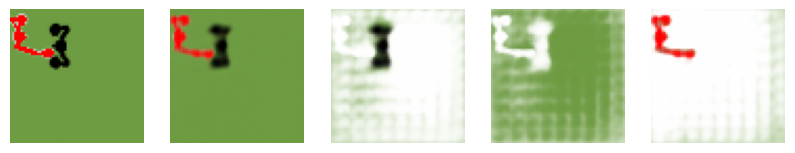

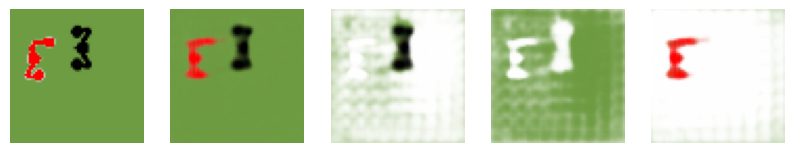

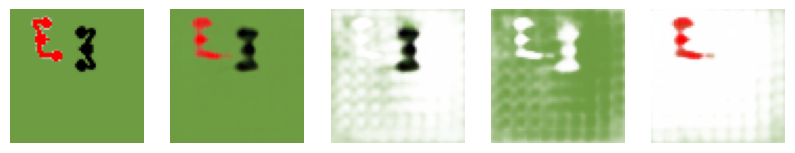

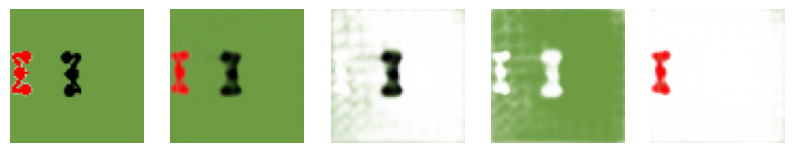

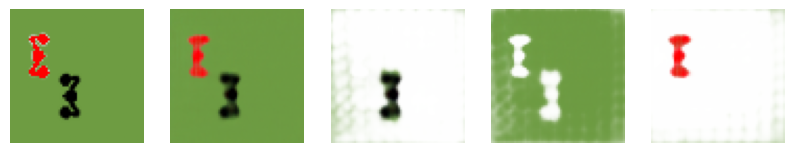

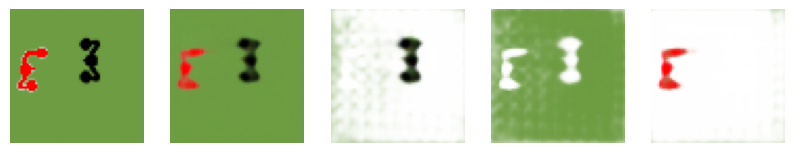

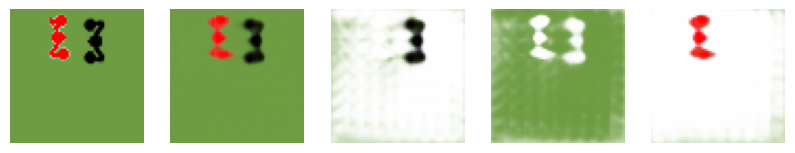

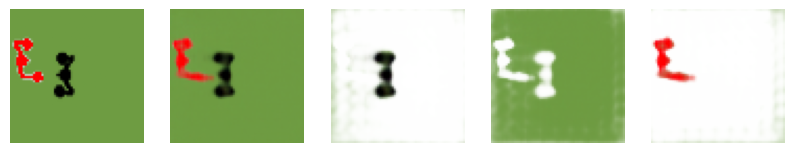

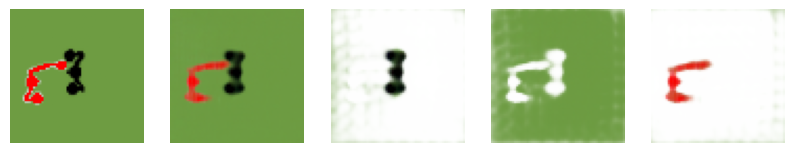

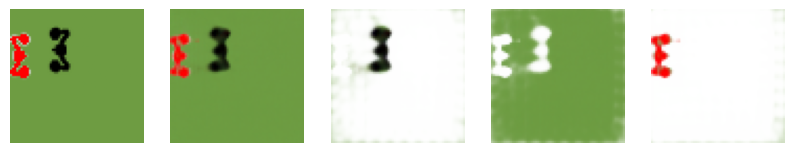

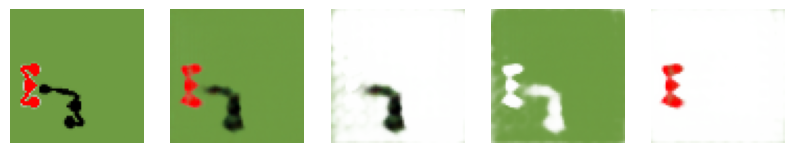

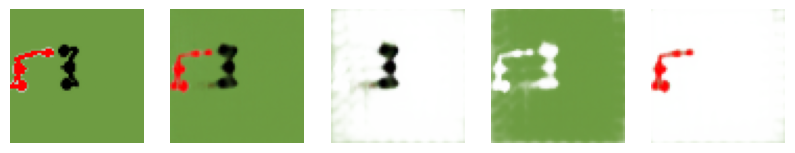

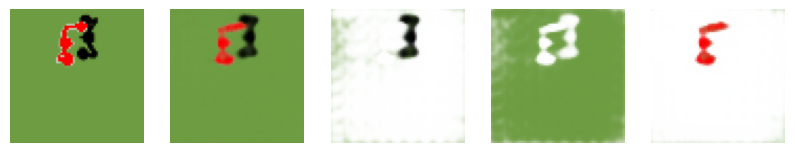

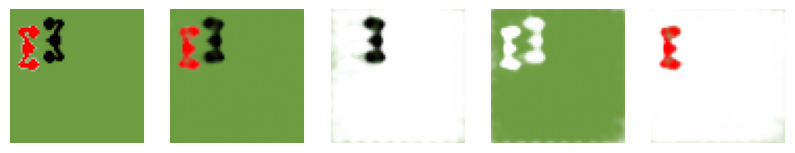

In [4]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    for idx, sample in enumerate(train_loader):
        image = sample["image"]
        recon_combined, recons, masks, slots = model(image)
        loss = criterion(recon_combined, image)
        total_loss = total_loss + loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            test(model, next(iter(train_loader)))